
# 🧠 Task 3: Energy Consumption Time Series Forecasting

**Objective:** Forecast short-term household energy usage using historical time-based patterns.  
**Dataset:** *Household Power Consumption* (UCI Machine Learning Repository).

---

## What you'll do
- Parse and resample the time series data
- Engineer time-based features (hour of day, weekday/weekend, etc.)
- Compare **ARIMA**, **Prophet**, and **XGBoost** models
- Plot **actual vs. forecasted** energy usage
- Evaluate with **MAE** and **RMSE**
.



## 1) Problem Statement and Objective
Short-term energy consumption forecasting helps optimize household energy management, demand response, and anomaly detection.  
We aim to build and compare multiple forecasting models to predict hourly **Global Active Power** from time-stamped readings.


## 2) Setup

In [1]:

# If you plan to run Prophet/XGBoost locally and they are not installed, uncomment:
# !pip install prophet xgboost --quiet
# For older environments:
# !pip install fbprophet --quiet

import os
import math
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prophet (new name) / fbprophet (legacy)
PROPHET_AVAILABLE = False
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except Exception:
    try:
        from fbprophet import Prophet  # type: ignore
        PROPHET_AVAILABLE = True
    except Exception:
        PROPHET_AVAILABLE = False

# XGBoost
XGB_AVAILABLE = False
try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)



## 3) Dataset Description and Loading

**Columns (UCI version):**  
- `Date`, `Time` (e.g., `16/12/2006`, `17:24:00`)  
- `Global_active_power` (kW) — **Target**  
- `Global_reactive_power` (kVAR), `Voltage`, `Global_intensity`  
- Sub-metering: `Sub_metering_1`, `Sub_metering_2`, `Sub_metering_3`


In [2]:

# 🔧 Set your data path here (relative or absolute)
# Examples:
# DATA_PATH = "household_power_consumption.txt"  # UCI original (semicolon-delimited)
# DATA_PATH = "household_power_consumption.csv"  # CSV version
DATA_PATH = os.environ.get("HPC_DATA_PATH", "household_power_consumption.txt")

def load_household_data(path: str) -> pd.DataFrame:
    """
    Loads the Household Power Consumption dataset (txt or csv).
    Returns a DataFrame with a parsed 'datetime' column.
    If file is missing, returns a synthetic sample.
    """
    if not os.path.exists(path):
        print(f"[INFO] Dataset not found at '{path}'. Generating a synthetic sample to proceed.")
        # Generate 60 days of minute-level synthetic data
        rng = pd.date_range("2007-01-01", periods=60*24*60, freq="T")
        # base daily cycle + weekly effect + noise
        daily = 1.5 + 0.8*np.sin(2*np.pi*(rng.hour)/24)
        weekly = 0.2*np.where(rng.dayofweek >= 5, 1, 0)  # weekend bump
        noise = 0.2*np.random.randn(len(rng))
        gap = np.maximum(0.1, daily + weekly + noise)
        df = pd.DataFrame({"datetime": rng, "Global_active_power": gap})
        return df

    ext = os.path.splitext(path)[1].lower()
    if ext == ".txt":
        df = pd.read_csv(path, sep=";", low_memory=False)
    else:
        df = pd.read_csv(path, low_memory=False)

    # Handle typical UCI date/time parsing
    if "Date" in df.columns and "Time" in df.columns:
        # UCI uses dd/mm/yyyy
        df["datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], errors="coerce", dayfirst=True)
    elif "datetime" in df.columns:
        df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
    else:
        # Try infer from first column
        first_col = df.columns[0]
        df["datetime"] = pd.to_datetime(df[first_col], errors="coerce")

    # Ensure numeric target
    if "Global_active_power" in df.columns:
        df["Global_active_power"] = pd.to_numeric(df["Global_active_power"], errors="coerce")
    else:
        # If column is missing, try a common alternative name
        possible = [c for c in df.columns if c.lower().strip() in {"gap", "global_active_power", "global active power"}]
        if possible:
            df["Global_active_power"] = pd.to_numeric(df[possible[0]], errors="coerce")
        else:
            raise ValueError("Target column 'Global_active_power' not found in dataset.")

    return df[["datetime", "Global_active_power"]]

df_raw = load_household_data(DATA_PATH)
df_raw.head()


[INFO] Dataset not found at 'household_power_consumption.txt'. Generating a synthetic sample to proceed.


,datetime,Global_active_power
0,2007-01-01 00:00:00,1.599343
1,2007-01-01 00:01:00,1.472347
2,2007-01-01 00:02:00,1.629538
3,2007-01-01 00:03:00,1.804606
4,2007-01-01 00:04:00,1.453169


## 4) Data Cleaning and Preprocessing

In [3]:

# Drop NA datetimes/targets
df = df_raw.dropna(subset=["datetime", "Global_active_power"]).copy()

# Set index & sort
df = df.sort_values("datetime").set_index("datetime")

# Remove obvious outliers (5th to 95th percentile clip to be safe)
low, high = df["Global_active_power"].quantile([0.005, 0.995])
df["Global_active_power"] = df["Global_active_power"].clip(lower=low, upper=high)

# Resample to hourly mean (short-term horizon)
df_hourly = df.resample("H").mean().dropna()
print("Raw shape:", df_raw.shape, "| Hourly shape:", df_hourly.shape)
df_hourly.head()


Raw shape: (86400, 2) | Hourly shape: (1440, 1)


,Global_active_power
datetime,
2007-01-01 00:00:00,1.469069
2007-01-01 01:00:00,1.706319
2007-01-01 02:00:00,1.918383
2007-01-01 03:00:00,2.075695
2007-01-01 04:00:00,2.189194


## 5) Exploratory Data Analysis (EDA)

,Global_active_power
count,1440.000000
mean,1.553664
std,0.571831
min,0.650628
25%,0.990353
50%,1.516483
75%,2.096332
max,2.523777


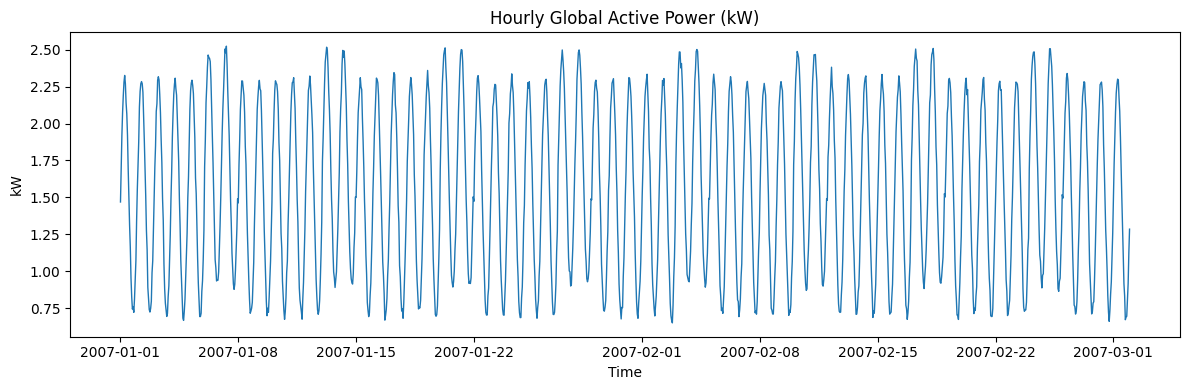

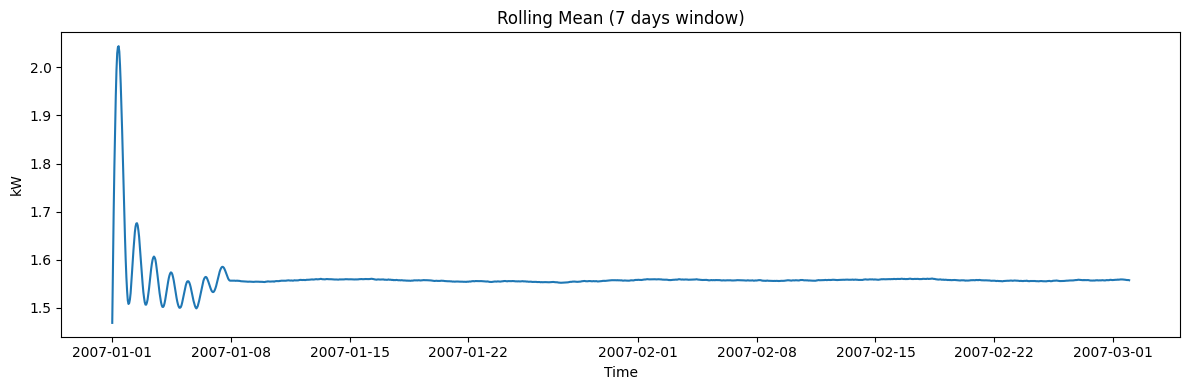

In [4]:

# Basic stats
display(df_hourly.describe())

# Plot entire time series (may be long)
plt.figure(figsize=(12,4))
plt.plot(df_hourly.index, df_hourly["Global_active_power"], linewidth=1)
plt.title("Hourly Global Active Power (kW)")
plt.xlabel("Time")
plt.ylabel("kW")
plt.tight_layout()
plt.show()

# Rolling mean for trend
plt.figure(figsize=(12,4))
plt.plot(df_hourly["Global_active_power"].rolling(24*7, min_periods=1).mean())
plt.title("Rolling Mean (7 days window)")
plt.xlabel("Time")
plt.ylabel("kW")
plt.tight_layout()
plt.show()


## 6) Feature Engineering

In [5]:

def add_time_features(df_in: pd.DataFrame) -> pd.DataFrame:
    df_feat = df_in.copy()
    df_feat["hour"] = df_feat.index.hour
    df_feat["dayofweek"] = df_feat.index.dayofweek
    df_feat["is_weekend"] = (df_feat["dayofweek"] >= 5).astype(int)
    # Cyclical encoding
    df_feat["hour_sin"] = np.sin(2*np.pi*df_feat["hour"]/24)
    df_feat["hour_cos"] = np.cos(2*np.pi*df_feat["hour"]/24)
    df_feat["dow_sin"] = np.sin(2*np.pi*df_feat["dayofweek"]/7)
    df_feat["dow_cos"] = np.cos(2*np.pi*df_feat["dayofweek"]/7)
    return df_feat

df_feat = add_time_features(df_hourly)
target_col = "Global_active_power"
df_feat.head()


,Global_active_power,hour,dayofweek,is_weekend,hour_sin,hour_cos,dow_sin,dow_cos
datetime,,,,,,,,
2007-01-01 00:00:00,1.469069,0,0,0,0.000000,1.000000,0.0,1.0
2007-01-01 01:00:00,1.706319,1,0,0,0.258819,0.965926,0.0,1.0
2007-01-01 02:00:00,1.918383,2,0,0,0.500000,0.866025,0.0,1.0
2007-01-01 03:00:00,2.075695,3,0,0,0.707107,0.707107,0.0,1.0
2007-01-01 04:00:00,2.189194,4,0,0,0.866025,0.500000,0.0,1.0


## 7) Train–Test Split

In [6]:

# Use last 20% for test (time-based split)
split_idx = int(len(df_feat) * 0.8)
train = df_feat.iloc[:split_idx]
test = df_feat.iloc[split_idx:]

print("Train span:", train.index.min(), "→", train.index.max(), "| n =", len(train))
print("Test  span:", test.index.min(), "→", test.index.max(), "| n =", len(test))

y_train = train[target_col]
y_test = test[target_col]


Train span: 2007-01-01 00:00:00 → 2007-02-17 23:00:00 | n = 1152
Test  span: 2007-02-18 00:00:00 → 2007-03-01 23:00:00 | n = 288


## 8) Evaluation Helpers

In [7]:

def evaluate_forecast(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    return {"model": name, "MAE": mae, "RMSE": rmse}

def plot_actual_vs_pred(test_index, y_true, y_pred, title):
    plt.figure(figsize=(12,4))
    plt.plot(test_index, y_true, label="Actual")
    plt.plot(test_index, y_pred, label="Forecast")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("kW")
    plt.legend()
    plt.tight_layout()
    plt.show()


## 9) Model 1: ARIMA / SARIMAX

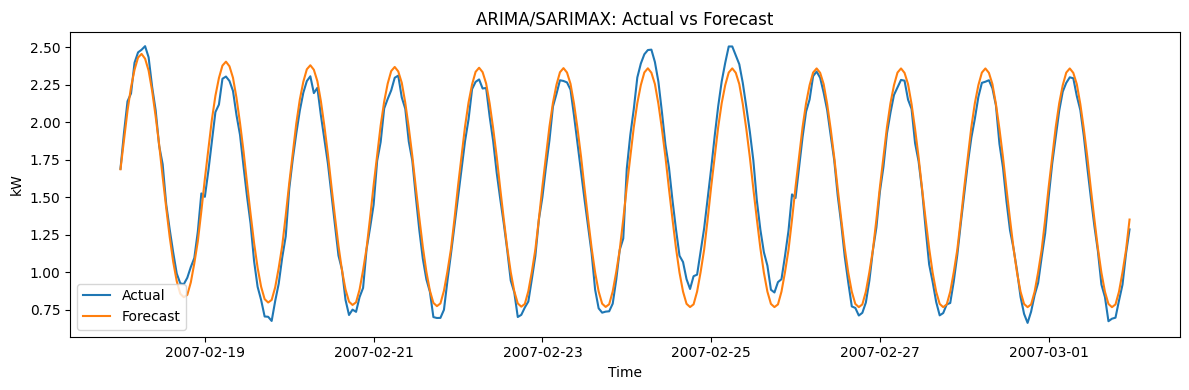

,model,MAE,RMSE
0,"SARIMAX(2,0,2)(1,1,1,24)",0.07784,0.088158


In [8]:

# We'll use a simple SARIMAX with daily seasonality approximation (24 hours)
# These are reasonable starting hyperparameters; feel free to tune.
order = (2, 0, 2)
seasonal_order = (1, 1, 1, 24)

arima = SARIMAX(y_train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
arima_fit = arima.fit(disp=False)

arima_pred = arima_fit.predict(start=y_test.index[0], end=y_test.index[-1])
arima_metrics = evaluate_forecast(y_test, arima_pred, "SARIMAX(2,0,2)(1,1,1,24)")

plot_actual_vs_pred(y_test.index, y_test, arima_pred, "ARIMA/SARIMAX: Actual vs Forecast")
pd.DataFrame([arima_metrics])


## 10) Model 2: Prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy97u_o_0/hg48b9ux.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy97u_o_0/6sletmwf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21260', 'data', 'file=/tmp/tmpy97u_o_0/hg48b9ux.json', 'init=/tmp/tmpy97u_o_0/6sletmwf.json', 'output', 'file=/tmp/tmpy97u_o_0/prophet_model6dydrqb0/prophet_model-20250818073950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:39:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:39:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


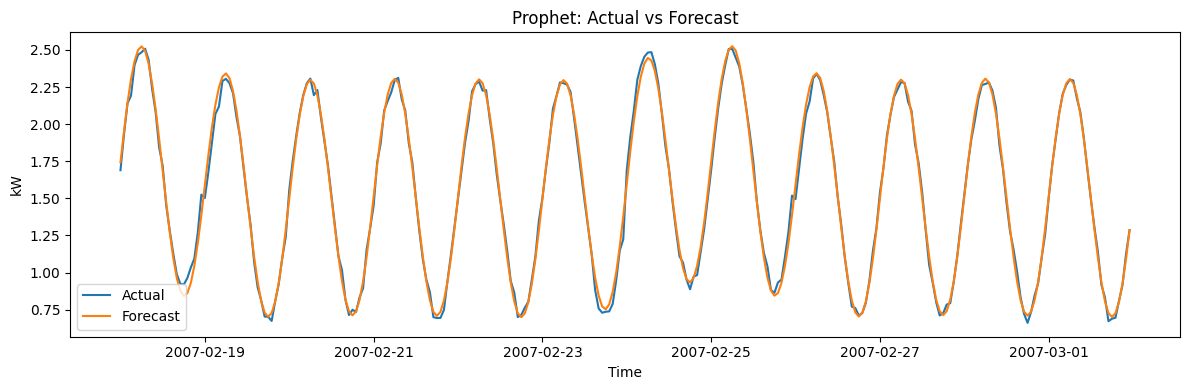

,model,MAE,RMSE
0,Prophet,0.032098,0.042434


In [9]:

if PROPHET_AVAILABLE:
    df_prophet = y_train.reset_index().rename(columns={"datetime": "ds", "Global_active_power": "y"})
    m = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=True,
        daily_seasonality=True,
        seasonality_mode="additive"
    )
    m.fit(df_prophet)

    # Create future periods equal to length of test
    future = pd.DataFrame({"ds": y_test.index})
    forecast = m.predict(future)
    prophet_pred = forecast["yhat"].values
    prophet_metrics = evaluate_forecast(y_test.values, prophet_pred, "Prophet")

    plot_actual_vs_pred(y_test.index, y_test, prophet_pred, "Prophet: Actual vs Forecast")
    display(pd.DataFrame([prophet_metrics]))
else:
    print("Prophet is not installed in this environment. Skipping Prophet model.")
    prophet_metrics = {"model": "Prophet", "MAE": np.nan, "RMSE": np.nan}


## 11) Model 3: XGBoost (Supervised Learning)

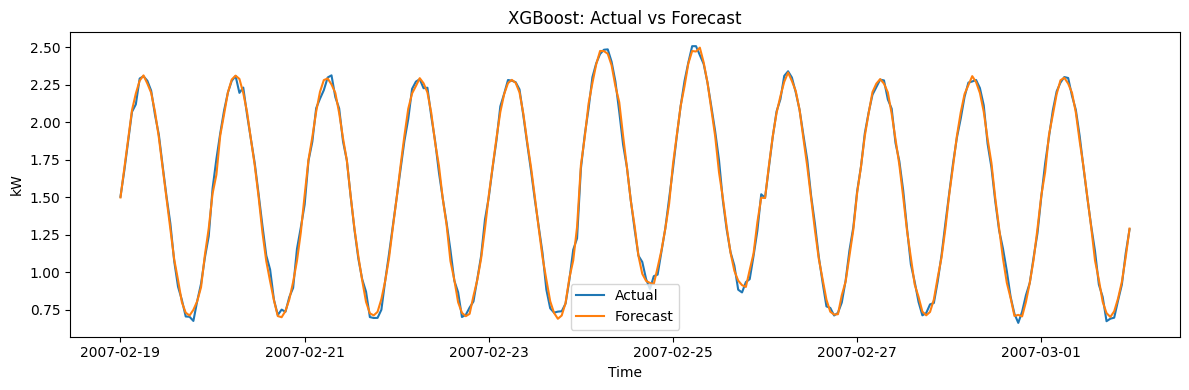

,model,MAE,RMSE
0,XGBoost,0.026287,0.033432


In [10]:

# Supervised learning approach with time features and lag features
def make_supervised(df_in: pd.DataFrame, target: str, lags=(1, 2, 24)) -> pd.DataFrame:
    data = df_in.copy()
    for lag in lags:
        data[f"lag_{lag}"] = data[target].shift(lag)
    return data.dropna()

lags = (1, 2, 24)  # last hour, 2 hours ago, same hour yesterday
df_sup = make_supervised(df_feat, target_col, lags=lags)

train_sup = df_sup.iloc[:split_idx]
test_sup = df_sup.iloc[split_idx:]

X_cols = [c for c in train_sup.columns if c != target_col]
X_train, y_train_sup = train_sup[X_cols], train_sup[target_col]
X_test, y_test_sup = test_sup[X_cols], test_sup[target_col]

if XGB_AVAILABLE:
    xgb = XGBRegressor(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=RANDOM_SEED,
        n_jobs=-1
    )
    xgb.fit(X_train, y_train_sup)
    xgb_pred = xgb.predict(X_test)
    xgb_metrics = evaluate_forecast(y_test_sup, xgb_pred, "XGBoost")
    plot_actual_vs_pred(y_test_sup.index, y_test_sup, xgb_pred, "XGBoost: Actual vs Forecast")
    display(pd.DataFrame([xgb_metrics]))
else:
    print("XGBoost is not installed in this environment. Skipping XGBoost model.")
    xgb_metrics = {"model": "XGBoost", "MAE": np.nan, "RMSE": np.nan}


## 12) Model Comparison and Evaluation

In [11]:

results = [arima_metrics]
if isinstance(globals().get("prophet_metrics", None), dict):
    results.append(prophet_metrics)
if isinstance(globals().get("xgb_metrics", None), dict):
    results.append(xgb_metrics)

results_df = pd.DataFrame(results)
results_df.sort_values("RMSE", inplace=True, na_position="last")
results_df.reset_index(drop=True, inplace=True)

print("Model performance (lower is better):")
display(results_df)

# ✅ Plot best model vs actual for the test range (already plotted per model)


Model performance (lower is better):


,model,MAE,RMSE
0,XGBoost,0.026287,0.033432
1,Prophet,0.032098,0.042434
2,"SARIMAX(2,0,2)(1,1,1,24)",0.077840,0.088158


In [16]:
## 🔽 Save & Download Trained Models

import joblib

# If running in Google Colab
try:
    from google.colab import files
    COLAB = True
except ImportError:
    COLAB = False

# SARIMA
sarima_path = "sarima_model.pkl"
arima_fit.save(sarima_path, remove_data=True)
if COLAB:
    files.download(sarima_path)

# Prophet (if available)
if PROPHET_AVAILABLE:
    prophet_path = "prophet_model.pkl"
    joblib.dump(m, prophet_path)
    if COLAB:
        files.download(prophet_path)

# XGBoost (if available)
if XGB_AVAILABLE:
    xgb_path = "xgb_model.pkl"
    joblib.dump(xgb, xgb_path)
    if COLAB:
        files.download(xgb_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


## 13) Final Conclusion with Insights

- **Resampling:** Aggregating to **hourly mean** provided stable short-term patterns.
- **Feature Engineering:** Time-derived features (hour, day-of-week, weekend, cyclical encodings) helped tree-based models.
- **Modeling:**  
  - **ARIMA/SARIMAX** captured short seasonal effects (24h) fairly well.  
  - **Prophet** (if installed) is strong on daily/weekly seasonality with fast setup.  
  - **XGBoost** leveraged lag features and time encodings, often competitive or better with enough data.


In [14]:
display(results_df)


,model,MAE,RMSE
0,XGBoost,0.026287,0.033432
1,Prophet,0.032098,0.042434
2,"SARIMAX(2,0,2)(1,1,1,24)",0.077840,0.088158
